# Lecture 10:  Randomized linear algebra

## Brief recap of the previous lecture


SVD and algorithms for its computations: divide-and-conquer, QR, Jacobi, bisection.

## Todays lecture

Today, we will do a brief dive into the randomized NLA.

A good read is (https://arxiv.org/pdf/2002.01387.pdf)

## Random numbers

All the computations that we considered up to today were **deterministic**.

However, reduction of complexity can be done by using randomized (stochastic) computation.

Example: randomized matrix multiplication.


## Checking matrix equality
We can check, if $ A B = C$ in $\mathcal{O}(n^2)$ operations.

How? 

## [Freivalds algorithm](https://en.wikipedia.org/wiki/Freivalds%27_algorithm)

Checks by multiplying by random vectors! 

Complexity is $k n^2$, probability is of failure is $\frac{1}{2^k}$.


## Matrix multiplication

But can we multiply matrices faster using randomization ideas?

## Randomized matrix multiplication

- We know that matrix multiplication $AB$ costs $O(mnp)$ for matrices $m \times p$ and $p \times n$
- We can construct approximation of this product by sampling rows and columns of the multipliers

**Q:** how to sample them?

**A:** generate probabilities from their norms!

- So the final approximation expression

$$ AB \approx \sum_{t=1}^k \frac{1}{kp_{i_t}} A^{(i_t)} B_{(i_t)}, $$

where $A^{(i_t)}$ is a column of $A$ and $B_{(i_t)}$ is a row of $B$

- Complexity reduction from $O(mnp)$ to $O(mnk)$

In [9]:
import numpy as np

n = 20
p = 1000
m = 20
A = np.random.randn(n, p)
B = np.random.randn(p, m)
C = A @ B

def randomized_matmul(A, B, k):
    p = np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=1)
    p = p.ravel() / p.sum()
    n = A.shape[1]
    idx = np.random.choice(np.arange(n), (k,), False, p)
    d = 1 / np.sqrt(k * p[idx])
    A_sketched = A[:, idx] * d[None, :]
    B_sketched = B[idx, :] * d[:, None]
    C = A_sketched @ B_sketched
    return C

def randomized_matmul_topk(A, B, K):
    
    norm_mult = np.linalg.norm(A,axis=0) * np.linalg.norm(B,axis=1)
    top_k_idx = np.sort(np.argsort(norm_mult)[::-1][:K])
    
    A_top_k_cols = A[:, top_k_idx]
    B_top_k_rows = B[top_k_idx, :]

    C_approx = A_top_k_cols @ B_top_k_rows
    return C_approx

num_items = 300
C_appr_samples = randomized_matmul(A, B, num_items)
C_appr_topk = randomized_matmul_topk(A, B, num_items)
print(np.linalg.norm(C_appr_topk - C) / np.linalg.norm(C))
print(np.linalg.norm(C_appr_samples - C) / np.linalg.norm(C))

0.7278865806238983
1.5298073040685793


## Approximation error

$$ \mathbb{E} [\|AB - CR\|^2_F] = \frac{1}{k} \left(\sum_{i=1}^n \| A^{(i)} \|_2 \| B_{(i)} \|_2\right)^2   - \frac{1}{k}\|AB\|_F^2 $$ 

- Other sampling probabilities are possible
- Use approximation
$$ AB \approx ASD(SD)^\top B  = ACC^{\top}B$$
can replace sampling and scaling with another matrix that
    
    - reduces the dimension
    - sufficiently accurately approximates

**Q:** what matrices can be used?

### Stochastic trace estimator


Many problems can be written in the form of the trace estimation:

$$\mathrm{Tr}(A) = \sum_{i} A_{ii}.$$

Can we compute the trace of the matrix if we only have access to matrix-by-vector products?

## Two estimators

The randomized trace estimators can be computed from the following formula:

$$\mathrm{Tr}(A) = E_w w^* A w, \quad E ww_* = 1$$ 

In order to sample, we pick $k$ independent samples of $w_k$, get random variable $X_k$ and average the results.

**Girard trace estimator**: Sample $w \sim N(0, 1)$

Then, $\mathrm{Var} X_k = \frac{2}{k} \sum_{i, j=1}^n \sum_{i=1}^n \vert A_{ij} \vert^2 = \frac{2}{k} \Vert A \Vert^2_F$

**Hutchinson trace estimator**: Let $w$ be a Rademacher random vector (i.e., elements are sampled from the uniform distribution.

It gives the minimal variance estimator.

## Intdim

The variance of the trace can be estimated in terms of **intrinsic dimension** (intdim) for symmetric positive definite matrices.

It is defined as $\mathrm{intdim}(A) = \frac{\mathrm{Tr}(A)}{\Vert A \Vert_F}$. It is easy to show that

$$1 \leq \mathrm{intdim}(A) \leq r.$$

Then, the probability of the large deviation can be estimated as 

$$P( \vert \overline{X}_k - \mathrm{Tr}(A) \vert \geq t \mathrm{Tr}(A)) \leq \frac{2}{k \mathrm{intdim}(A) t^2}$$

## Better bounds for SPD matrices

If $A$ is SPD, then

$$P(\overline{X}_k \geq \tau \mathrm{Tr}(A) ) \leq \exp\left(-1/2 \mathrm{intdim}(A) (\sqrt{\tau} - 1)^2)\right) $$

Similar inequality holds for the lower bound.

This estimate is much better.

An interesting (and often mislooked) property of stochastic estimator is that it comes with a stochastic variance estimate
(from samples!)

Warning: we still need $\varepsilon^{-2}$ samples to get to the accuracy $\varepsilon$ when using independent samples.

### Distances between languages ([original paper](https://openreview.net/pdf?id=HyebplHYwB))

<img src="./gw_matexp.png">

## Where do stochastic methods also help?

- SVD
- Linear systems
- Matrix multiplication

## Randomized SVD ([Halko et al, 2011](https://epubs.siam.org/doi/pdf/10.1137/090771806?casa_token=isi3yX3QdPEAAAAA:j-7Qk87vS0kjKqGMLYeX3xg4QxqqyM8s4wn-XGX-SLOS2BRChFDRTPX-x9Hf7ltfuZYg9xsA0zksw1U))

- Problem statement reminder

$$ A \approx U\Sigma V^\top, $$

where $A$ is of size $m \times n$, $U$ is of size $m \times k$ and $V$ is of size $n \times k$.

- We have already known that the complexity of rank-$k$ approximation is $O(mnk)$
- How can we reduce this complexity?

- Assume we know orthogonal matrix $Q$ of size $m \times k$ such that 

$$A \approx Q Q^{\top}A $$

- In other words, columns of $Q$ represent orthogonal basis in the column space of matrix $A$
- Then the following deterministic steps can give the factors $U$, $\Sigma$ and $V$ corresponding of SVD of matrix $A$
    - Form $k \times n$ matrix $B = Q^{\top}A$
    - Compute SVD of small matrix $B = \hat{U}\Sigma V^{\top}$
    - Update left singular vectors $U = Q\hat{U}$
    
- If $k \ll \min(m, n)$ then these steps can be performed fast
- If $Q$ forms exact basis in column space of $A$, then $U$, $\Sigma$ and $V$ are also exact!
- So, how to compose matrix $Q$?

### Randomized approximation of basis in column space of $A$

- The main approach
    - Generate $k + p$ Gaussian vectors of size $m$ and form matrix $G$
    - Compute $Y = AG$
    - Compute QR decomposition of $Y$ and use the resulting matrix $Q$ as an approximation of the basis 
- Parameter $p$ is called **oversampling** parameter and is needed to improve approximation of the leading $k$ left singular vectors later
- Computing of $Y$ can be done in parallel
- Here we need only matvec function for matrix $A$ rather than its elements as a 2D array - black-box concept!
- Instead of Gaussian random matrix one can use more structured but still random matrix that can be multiplied by $A$ fast

Error from randomized SVD 1407.4512171333674
Error from exact SVD 1192.1659039032784


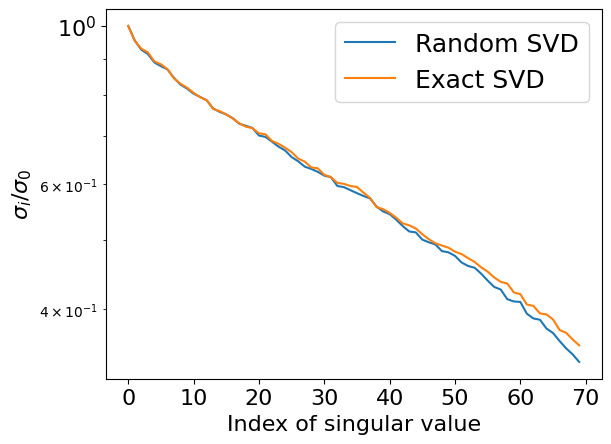

In [2]:
import matplotlib.pyplot as plt
import numpy as np

n = 1000
k = 100
m = 200
# Lowrank matrix
A = np.random.randn(n, k)
B = np.random.randn(k, m)
A = A @ B

# Random matrix
# A = np.random.randn(n, m)

def randomized_svd(A, rank, p):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

rank = 70
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")
u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [4]:
import scipy.sparse.linalg as spsplin
# More details about Facebook package for computing randomized SVD is here: https://research.fb.com/blog/2014/09/fast-randomized-svd/ 
import fbpca
n = 1000
m = 200
A = np.random.randn(n, m)
k = 10
p = 10
%timeit spsplin.svds(A, k=k)
%timeit randomized_svd(A, k, p)
%timeit fbpca.pca(A, k=k, raw=False) 

59.7 ms ± 6.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.7 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.5 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Convergence theorem

The averaged error of the presented algorithm, where $k$ is target rank and $p$ is oversampling parameter, is the following
- in Frobenius norm

$$ \mathbb{E}\|A - QQ^{\top}A \|_F \leq \left( 1 + \frac{k}{p-1} \right)^{1/2}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2}  $$

- in spectral norm

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^2_j \right)^{1/2} $$

The expectation is taken w.r.t. random matrix $G$ generated in the method described above.

Compare these upper bounds with Eckart-Young theorem. Are these bounds good?



## Accuracy enhanced randomized SVD

- Main idea: power iteration
- If $A = U \Sigma V^\top$, then $A^{(q)} = (AA^{\top})^qA = U \Sigma^{2q+1}V^\top $, where $q$ some small natural number, e.g. 1 or 2
- Then we sample from $A^{(q)}$, not from $A$

$$ Y = (AA^{\top})^qAG \qquad Q, R = \mathtt{qr}(Y) $$

- The main reason: if singular values of $A$ decays slowly, the singular values of $A^{(q)}$ will decay faster 

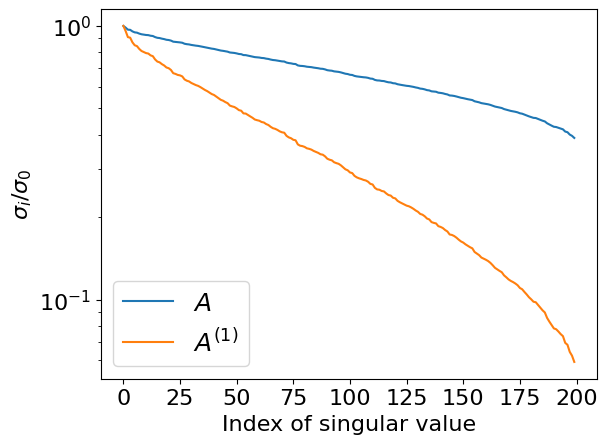

In [5]:
n = 1000
m = 200
A = np.random.randn(n, m)
s = np.linalg.svd(A, compute_uv=False)
Aq = A @ A.T @ A
sq = np.linalg.svd(Aq, compute_uv=False)
plt.semilogy(s / s[0], label="$A$")
plt.semilogy(sq / sq[0], label="$A^{(1)}$")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

### Loss of accuracy with rounding errors

- Compose $A^{(q)}$ naively leads to condition number grows and loss of accuracy

**Q:** how can we battle with this issue?

**A:** sequential orthogonalization!

Error from randomized SVD 288.7036072943936
Error from more accurate randomized SVD 251.96132041204794
Error from exact SVD 250.99500770611198


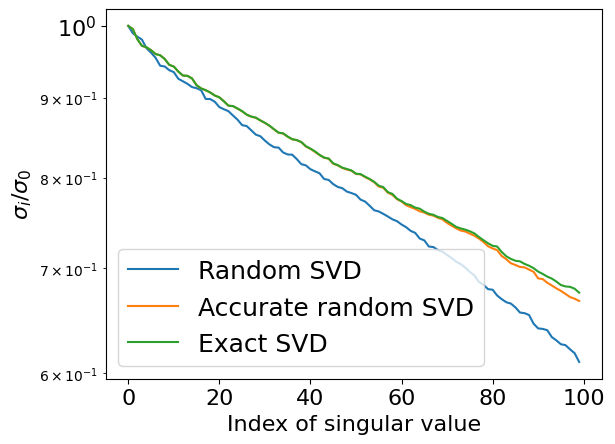

In [6]:
def more_accurate_randomized_svd(A, rank, p, q):
    m, n = A.shape
    G = np.random.randn(n, rank + p)
    Y = A @ G
    Q, _ = np.linalg.qr(Y)
    for i in range(q):
        W = A.T @ Q
        W, _ = np.linalg.qr(W)
        Q = A @ W
        Q, _ = np.linalg.qr(Q)
    B = Q.T @ A
    u, S, V = np.linalg.svd(B)
    U = Q @ u
    return U, S, V

n = 1000
m = 200
A = np.random.randn(n, m)

rank = 100
p = 20
U, S, V = randomized_svd(A, rank, p)
print("Error from randomized SVD", np.linalg.norm(A - U[:, :rank] * S[None, :rank] @ V[:rank, :]))
plt.semilogy(S[:rank] / S[0], label="Random SVD")

Uq, Sq, Vq = more_accurate_randomized_svd(A, rank, p, 5)
print("Error from more accurate randomized SVD", np.linalg.norm(A - Uq[:, :rank] * Sq[None, :rank] @ Vq[:rank, :]))
plt.semilogy(Sq[:rank] / Sq[0], label="Accurate random SVD")

u, s, v = np.linalg.svd(A)
print("Error from exact SVD", np.linalg.norm(A - u[:, :rank] * s[None, :rank] @ v[:rank, :]))
plt.semilogy(s[:rank] / s[0], label="Exact SVD")
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$\sigma_i / \sigma_0$", fontsize=16)
_ = plt.xlabel("Index of singular value", fontsize=16)

In [7]:
%timeit spsplin.svds(A, k=k)
%timeit fbpca.pca(A, k=k, raw=False)
%timeit randomized_svd(A, k, p) 
%timeit more_accurate_randomized_svd(A, k, p, 1)
%timeit more_accurate_randomized_svd(A, k, p, 2)
%timeit more_accurate_randomized_svd(A, k, p, 5)

58.9 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.6 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.9 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
46 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
76.2 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Convergence theorem

The presented above method provides the following upper bound

$$ \mathbb{E}\|A - QQ^{\top}A \|_2 \leq \left[\left( 1 + \sqrt{\frac{k}{p-1}} \right)\sigma^{2q+1}_{k+1} + \frac{e\sqrt{k+p}}{p}\left( \sum_{j=k+1}^{\min(m, n)} \sigma^{2(2q+1)}_j \right)^{1/2}\right]^{1/(2q+1)} $$

Consider the worst case, where no lowrank structure exists in the given matrix.

**Q:** what is the degree of suboptimality w.r.t. Eckart-Young theorem? 

### Summary on randomized SVD

- Efficient method to get approximate SVD
- Simple to implement
- It can be extended to one-pass method, where matrix $A$ is needed only to construct $Q$
- It requires only matvec with target matrix

## Kaczmarz method to solve linear systems 

- We have already discussed how to solve overdetermined linear systems $Ax = f$ in the least-squares manner
    - pseudoinverse matrix
    - QR decomposition
- One more approach is based on iterative projections a.k.a. **Kaczmarz method** or **algebraic reconstruction technique** in compoutational tomography domain
- Instead of solving all equations, pick one randomly, which reads

$$a^{\top}_i x = f_i,$$

and given an approximation $x_k$ try to find $x_{k+1}$ as 

$$x_{k+1} = \arg \min_x \frac12 \Vert x - x_k \Vert^2_2, \quad \mbox{s.t.} \quad  a^{\top}_i x = f_i.$$

- A simple analysis gives 

$$x_{k+1} = x_k - \frac{(a_i, x_k) - f_i}{(a_i, a_i)} a_i. $$

- A cheap update, but the analysis is quite complicated.
- You can recognize in this method stochastic gradient descent with specific step size equal to $\frac{1}{\|a_i\|_2^2}$ for every sample

## Convergence theorem

- Assume we generate $i$ according to the distribution over the all available indices proportional to norms of the rows, i.e. $\mathbb{P}[i = k] = \frac{\|a_k\|_2^2}{\| A \|^2_F}$. This method is called Randomized Kaczmarz method (RKM)
- Why sampling strategy is important here?
- Investigation of the best sampling is provided [here](https://scholar.harvard.edu/files/yuelu/files/randkac_globalsip14.pdf)
- If the overdetermined linear system is **consistent**, then

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2], $$

where $\kappa_F(A) = \frac{\| A \|_F}{\sigma_{\min}(A)}$ and $\sigma_{\min}(A)$ is a minimal non-zero singular value of $A$. This result was presented in ([Strohmer and Vershynin, 2009](http://people.eecs.berkeley.edu/~brecht/cs294docs/week1/09.Strohmer.pdf))

- If the overdetermined linear system is **inconsistent**, then

$$ \mathbb{E}[\|x_{k+1} - x^*\|^2_2] \leq \left(1 - \frac{1}{\kappa^2_F(A)}\right) \mathbb{E}[\|x_{k} - x^*\|^2_2] + \frac{\|r^*\|_2^2}{\| A \|^2_F}, $$

where $r^* = Ax^* - f$

### Inconsistent overdetermined linear system

- It was shown in ([Needell, 2010](https://arxiv.org/pdf/0902.0958.pdf)) that RKM does not converge to $A^{\dagger}f$
- To address this issue Randomized extended Kaczmarz method was proposed in ([A Zouzias, N Freris, 2013](https://arxiv.org/pdf/1205.5770.pdf))
- The main idea is to use two steps of RKM:
    - the first step is for system $A^\top z = 0$ starting from $z_k$
    
    $$ z^{k+1} = z^{k} - \frac{a^\top_{:, j} z^k}{\| a_{:, j} \|_2^2}a_{:, j}  $$ 
    
    - the second step is for system $Ax = f - z_{k+1}$ starting from $x_k$
    
    $$x^{k+1} = x^k - \frac{a_{i,:}x_k - f_i + z^{k+1}_i}{\|a_{i,:}\|_2^2}a^{\top}_{i,:} $$
    
Here $a_{:, j}$ denotes the $j$-th column of $A$ and $a_{i, :}$ denotes the $i$-th row of $A$

- If $z^0 \in f + \mathrm{range}(A)$ and $x^0 \in \mathrm{range}(A^\top)$, then REK converges exponentially to $A^{\dagger}f$ 

## Sampling and sketching

- Sampling of a particular row can be considered as a particular case of more general approach called **sketching**
- Idea: replace matrix $A$ with another matrix $SA$, where matrix $SA$ has significantly smaller number of rows but preserves some important properties of matrix $A$
- Possible choices:
    - random projection
    - random row selection
- Example: linear least squares problem $\|Ax - b\|_2^2 \to \min_x$ transforms to $\| (SA)y - Sb \|_2^2 \to \min_y$ and we expect that $x \approx y$
- [Blendenpick](https://pdos.csail.mit.edu/~petar/papers/blendenpik-v1.pdf) solver is based on that idea and outperforms LAPACK routine 
- More details see in [Sketching as a Tool for Numerical Linear Algebra](https://researcher.watson.ibm.com/researcher/files/us-dpwoodru/wNow3.pdf) by D. Woodruff

## Coherence

The key idea is the coherence of the matrix.

Let $A$ be $n \times r$ and $U$ be an orthogonal matrix whose columns form the basis of the column space of $A$.

Then, coherence is defined as

$$\mu(A) = \max \Vert U_{i, *} \Vert^2$$

Coherence is always smaller than $1$ and bigger than $\frac{r}{n}$, it has nothing to do with the condition number.

What does it mean? 

## Coherence

Small coherence means, that sampling rows uniformly gives a good preconditioner (will be covered later in the course, and why it is important)

One can do $S A = QR$, and look at the condition number of $AR^{-1}$.

### Summary on randomized methods in solving linear systems

- Easy to use family of methods
- Especially useful in problems with streaming data
- Existing theoretical bounds for convergence
- Many interpretations in different domains (SGD in deep learning, ART in computational tomography)

### Summary on randomized matmul

- Simple method to get approximation of result
- Can be used if the high accuracy is not crucial
- Especially useful for large dense matrices

## Next lecture
- We start **sparse and/or structured** NLA.

# Questions?

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()